In [1]:
%matplotlib notebook

In [1]:
import tensorflow as tf

import numpy as np

from pilco.environments import Environment
from pilco.policies import RBFPolicy, SineBoundedActionPolicy
from pilco.costs import EQCost
from pilco.agents import EQGPAgent

import not_tf_opt as ntfo

from tqdm.notebook import trange

import matplotlib.pyplot as plt

ImportError: cannot import name 'RBFPolicy' from 'pilco.policies' (/Users/stratis/Documents/sbrml/pilco/pilco/policies/__init__.py)

In [ ]:
dtype = tf.float64

# Create pendulum environment from Gym
env = Environment(name='Pendulum-v0')
env.reset()

# Create stuff for our controller
# Upright position, stationary and zero action position for pendulum is [0, 0, 0]
target_loc = tf.zeros([1, 2])
target_scale = 1.

eq_cost = EQCost(target_loc=target_loc,
                 target_scale=target_scale,
                 dtype=dtype)

# create EQ policy
eq_policy = RBFPolicy(state_dim=2,
                      action_dim=1,
                      num_rbf_features=50,
                      dtype=dtype)

eq_policy = SineBoundedActionPolicy(eq_policy,
                                    lower=-2,
                                    upper=2)

# create agent
eq_agent = EQGPAgent(state_dim=2,
                     action_dim=1,
                     policy=eq_policy,
                     cost=eq_cost,
                     dtype=dtype)

In [ ]:
num_episodes = 50
num_steps = 1

eq_agent.policy.reset()

for episode in trange(num_episodes):
    
    state = env.reset()
    
    state = np.array([np.pi, 8]) * (2 * np.random.uniform(size=(2,)) - 1)
    env.env.env.state = state
    
    for step in range(num_steps):
        
        action = tf.random.uniform(shape=()) * 4. - 2
        state, action, next_state = env.step(action[None].numpy())
        
        eq_agent.observe(state, action, next_state)

In [5]:
horizon = 20
num_optim_steps = 30
num_episodes = 10
num_experience_steps = 20

tolerance = 1e-5

init_state = tf.constant([[-np.pi, 0.]], dtype=tf.float64)
init_cov = tf.eye(2, dtype=tf.float64)

agent_optimizer = tf.optimizers.Adam(1e-1)
optimiser = tf.optimizers.Adam(1e-1)

for episode in range(num_episodes):

    print('Optimising policy')
    
    prev_loss = np.inf
    
    eq_agent.set_eq_scales_from_data()
    
#     for n in trange(num_optim_steps):
#         with tf.GradientTape(watch_accessed_variables=False) as tape:
#             tape.watch(eq_agent.parameters)
            
#             loss = -eq_agent.dynamics_log_marginal()
            
#         gradients = tape.gradient(loss, eq_agent.parameters)
#         agent_optimizer.apply_gradients(zip(gradients, eq_agent.parameters))
        
#         eq_agent.eq_scales.assign(tf.clip_by_value(eq_agent.eq_scales(), 0., 1.))
    
#         print(loss)

#         if tf.abs(loss - prev_loss) < tolerance:
#             print(f"Early convergence!")
#             break
#         prev_loss = loss
        
#     print(f"GP length scales:\n{eq_agent.eq_scales()}")
#     print(f"GP variance:\n{eq_agent.eq_coeff()}")
#     print(f"GP length scales:\n{eq_agent.eq_noise_coeff()}")
    
    eq_agent.policy.reset()
    
    prev_loss = np.inf
    for n in trange(num_optim_steps):

        cost = 0.
        loc = init_state
        cov = init_cov

        with tf.GradientTape(watch_accessed_variables=False) as tape:

            tape.watch(eq_agent.policy.parameters)

            for t in range(horizon):

                mean_full, cov_full = eq_agent.policy.match_moments(loc, cov)

                loc, cov = eq_agent.match_moments(mean_full, cov_full)

                cost = cost + eq_agent.cost.expected_cost(loc[None, :], cov)

        gradients = tape.gradient(cost, eq_agent.policy.parameters)

        optimiser.apply_gradients(zip(gradients, eq_agent.policy.parameters))

        if tf.abs(cost - prev_loss) < tolerance:
            print(f"Early convergence!")
            break
            
        prev_loss = cost
        
        print(cost)
    
    print(cost)
        
    print(f'Performing episode {episode + 1}:')
    
    state = env.reset()
    
    for step in trange(num_experience_steps):
        
        action = eq_agent.act(state)
        state, action, next_state = env.step(action[None].numpy())
        eq_agent.observe(state, action, next_state)

Optimising policy


tf.Tensor(19.66056339228979, shape=(), dtype=float64)
tf.Tensor(19.545622998891716, shape=(), dtype=float64)
tf.Tensor(19.438018435144897, shape=(), dtype=float64)
tf.Tensor(19.470261786320048, shape=(), dtype=float64)
tf.Tensor(19.474121567380063, shape=(), dtype=float64)
tf.Tensor(19.442259519512675, shape=(), dtype=float64)
tf.Tensor(19.402192204638705, shape=(), dtype=float64)
tf.Tensor(19.395970768463236, shape=(), dtype=float64)
tf.Tensor(19.40754461618018, shape=(), dtype=float64)
tf.Tensor(19.402226919827957, shape=(), dtype=float64)
tf.Tensor(19.37715802671379, shape=(), dtype=float64)
tf.Tensor(19.349479119619346, shape=(), dtype=float64)
tf.Tensor(19.34029265513757, shape=(), dtype=float64)
tf.Tensor(19.33925760615296, shape=(), dtype=float64)
tf.Tensor(19.322318546663677, shape=(), dtype=float64)
tf.Tensor(19.295567491862993, shape=(), dtype=float64)
tf.Tensor(19.286182238639807, shape=(), dtype=float64)
tf.Tensor(19.286622140001533, shape=(), dtype=float64)
tf.Tensor(19.26


Optimising policy


tf.Tensor(19.716174856699613, shape=(), dtype=float64)
tf.Tensor(19.70469704975494, shape=(), dtype=float64)
tf.Tensor(19.69307739154952, shape=(), dtype=float64)
tf.Tensor(19.685925195370316, shape=(), dtype=float64)
tf.Tensor(19.682948177837527, shape=(), dtype=float64)
tf.Tensor(19.682069982510967, shape=(), dtype=float64)
tf.Tensor(19.68190281616061, shape=(), dtype=float64)
Early convergence!
tf.Tensor(19.681904297083644, shape=(), dtype=float64)
Performing episode 2:



Optimising policy


tf.Tensor(19.731025036765008, shape=(), dtype=float64)
tf.Tensor(19.72078774894665, shape=(), dtype=float64)
tf.Tensor(19.696062638781562, shape=(), dtype=float64)
tf.Tensor(19.65649106428499, shape=(), dtype=float64)
tf.Tensor(19.615780266751337, shape=(), dtype=float64)
tf.Tensor(19.596312284840813, shape=(), dtype=float64)
tf.Tensor(19.596503374156427, shape=(), dtype=float64)
tf.Tensor(19.598360873676903, shape=(), dtype=float64)
tf.Tensor(19.592532387867337, shape=(), dtype=float64)
tf.Tensor(19.574733369185232, shape=(), dtype=float64)
tf.Tensor(19.544348407010443, shape=(), dtype=float64)
tf.Tensor(19.516185804980193, shape=(), dtype=float64)
tf.Tensor(19.517125936060022, shape=(), dtype=float64)
tf.Tensor(19.53222024683218, shape=(), dtype=float64)
tf.Tensor(19.535102719432558, shape=(), dtype=float64)
tf.Tensor(19.521735557620538, shape=(), dtype=float64)
tf.Tensor(19.49961545936417, shape=(), dtype=float64)
tf.Tensor(19.483331485739892, shape=(), dtype=float64)
tf.Tensor(19.4


Optimising policy


tf.Tensor(19.497814514849157, shape=(), dtype=float64)
tf.Tensor(19.584431440277445, shape=(), dtype=float64)
tf.Tensor(19.599256130728868, shape=(), dtype=float64)
tf.Tensor(19.484376114725453, shape=(), dtype=float64)
tf.Tensor(19.652607443794302, shape=(), dtype=float64)
tf.Tensor(19.546646144239087, shape=(), dtype=float64)
tf.Tensor(19.505875264153694, shape=(), dtype=float64)
tf.Tensor(19.577396551655323, shape=(), dtype=float64)
tf.Tensor(19.552636691651646, shape=(), dtype=float64)
tf.Tensor(19.46773060603044, shape=(), dtype=float64)
tf.Tensor(19.532821804133704, shape=(), dtype=float64)
tf.Tensor(19.517033998721654, shape=(), dtype=float64)
tf.Tensor(19.45240725690466, shape=(), dtype=float64)
tf.Tensor(19.50992166146169, shape=(), dtype=float64)
tf.Tensor(19.487951101893323, shape=(), dtype=float64)
tf.Tensor(19.450185582433743, shape=(), dtype=float64)
tf.Tensor(19.49253788642169, shape=(), dtype=float64)
tf.Tensor(19.445533500091184, shape=(), dtype=float64)
tf.Tensor(19.4


Optimising policy


tf.Tensor(19.601227695746907, shape=(), dtype=float64)
tf.Tensor(19.55545562979771, shape=(), dtype=float64)
tf.Tensor(19.494981673979662, shape=(), dtype=float64)
tf.Tensor(19.530097431472225, shape=(), dtype=float64)
tf.Tensor(19.524262798700477, shape=(), dtype=float64)
tf.Tensor(19.46138978360772, shape=(), dtype=float64)
tf.Tensor(19.492625520791513, shape=(), dtype=float64)
tf.Tensor(19.50762814915265, shape=(), dtype=float64)
tf.Tensor(19.464991092659858, shape=(), dtype=float64)
tf.Tensor(19.463567663053933, shape=(), dtype=float64)
tf.Tensor(19.467275230170543, shape=(), dtype=float64)
tf.Tensor(19.42949345998358, shape=(), dtype=float64)
tf.Tensor(19.44881268422102, shape=(), dtype=float64)
tf.Tensor(19.447357784636356, shape=(), dtype=float64)
tf.Tensor(19.431033978079867, shape=(), dtype=float64)
tf.Tensor(19.445973034887142, shape=(), dtype=float64)
tf.Tensor(19.445486923129373, shape=(), dtype=float64)
tf.Tensor(19.432607141048443, shape=(), dtype=float64)
tf.Tensor(19.44


Optimising policy


tf.Tensor(19.493646556905674, shape=(), dtype=float64)
tf.Tensor(19.486871466832916, shape=(), dtype=float64)
tf.Tensor(19.47669926045574, shape=(), dtype=float64)
tf.Tensor(19.470034574603787, shape=(), dtype=float64)
tf.Tensor(19.466709332382866, shape=(), dtype=float64)
tf.Tensor(19.461768493728258, shape=(), dtype=float64)
tf.Tensor(19.45669816864733, shape=(), dtype=float64)
tf.Tensor(19.45523275508443, shape=(), dtype=float64)
tf.Tensor(19.45525518420438, shape=(), dtype=float64)
tf.Tensor(19.452617833790843, shape=(), dtype=float64)
tf.Tensor(19.447510558484694, shape=(), dtype=float64)
tf.Tensor(19.4433572724968, shape=(), dtype=float64)
tf.Tensor(19.44077852993659, shape=(), dtype=float64)
tf.Tensor(19.43761184247002, shape=(), dtype=float64)
tf.Tensor(19.435634054444602, shape=(), dtype=float64)
tf.Tensor(19.436341378186725, shape=(), dtype=float64)
tf.Tensor(19.435686720134296, shape=(), dtype=float64)
tf.Tensor(19.432998239658097, shape=(), dtype=float64)
tf.Tensor(19.43113


Optimising policy


tf.Tensor(19.6742827103063, shape=(), dtype=float64)
tf.Tensor(19.67288627293959, shape=(), dtype=float64)
tf.Tensor(19.67055467753335, shape=(), dtype=float64)
tf.Tensor(19.66725147739761, shape=(), dtype=float64)
tf.Tensor(19.662997595218012, shape=(), dtype=float64)
tf.Tensor(19.657978890017688, shape=(), dtype=float64)
tf.Tensor(19.652464689509053, shape=(), dtype=float64)
tf.Tensor(19.646303247849715, shape=(), dtype=float64)
tf.Tensor(19.638988403394986, shape=(), dtype=float64)
tf.Tensor(19.630078086030142, shape=(), dtype=float64)
tf.Tensor(19.61921851383467, shape=(), dtype=float64)
tf.Tensor(19.606254154212316, shape=(), dtype=float64)
tf.Tensor(19.591260630790472, shape=(), dtype=float64)
tf.Tensor(19.574673261402673, shape=(), dtype=float64)
tf.Tensor(19.5594262790214, shape=(), dtype=float64)
tf.Tensor(19.549557758536782, shape=(), dtype=float64)
tf.Tensor(19.54315869450182, shape=(), dtype=float64)
tf.Tensor(19.537022264995677, shape=(), dtype=float64)
tf.Tensor(19.530512


Optimising policy


tf.Tensor(19.80420622458894, shape=(), dtype=float64)
tf.Tensor(19.668068867066896, shape=(), dtype=float64)
tf.Tensor(19.629048360380562, shape=(), dtype=float64)
tf.Tensor(19.693075099619524, shape=(), dtype=float64)
tf.Tensor(19.707826623105834, shape=(), dtype=float64)
tf.Tensor(19.702985872870837, shape=(), dtype=float64)
tf.Tensor(19.690440369500532, shape=(), dtype=float64)
tf.Tensor(19.680645260552826, shape=(), dtype=float64)
tf.Tensor(19.677625141484427, shape=(), dtype=float64)
tf.Tensor(19.67826541832539, shape=(), dtype=float64)
tf.Tensor(19.679557273419526, shape=(), dtype=float64)
tf.Tensor(19.680471700988488, shape=(), dtype=float64)
tf.Tensor(19.68092913546111, shape=(), dtype=float64)
tf.Tensor(19.681082453248486, shape=(), dtype=float64)
Early convergence!
tf.Tensor(19.681078955239585, shape=(), dtype=float64)
Performing episode 8:



Optimising policy


tf.Tensor(19.713127142751315, shape=(), dtype=float64)
tf.Tensor(19.70596454059896, shape=(), dtype=float64)
tf.Tensor(19.69346096175561, shape=(), dtype=float64)
tf.Tensor(19.67551507038257, shape=(), dtype=float64)
tf.Tensor(19.653005821763163, shape=(), dtype=float64)
tf.Tensor(19.62943192341726, shape=(), dtype=float64)
tf.Tensor(19.606356501208026, shape=(), dtype=float64)
tf.Tensor(19.581852414428415, shape=(), dtype=float64)
tf.Tensor(19.56113843491319, shape=(), dtype=float64)
tf.Tensor(19.552129666685556, shape=(), dtype=float64)
tf.Tensor(19.549653446011234, shape=(), dtype=float64)
tf.Tensor(19.541873602789888, shape=(), dtype=float64)
tf.Tensor(19.528019254329916, shape=(), dtype=float64)
tf.Tensor(19.516695965765003, shape=(), dtype=float64)
tf.Tensor(19.506673221944567, shape=(), dtype=float64)
tf.Tensor(19.49148588717099, shape=(), dtype=float64)
tf.Tensor(19.475630238959575, shape=(), dtype=float64)
tf.Tensor(19.468363919091946, shape=(), dtype=float64)
tf.Tensor(19.465


Optimising policy


tf.Tensor(19.82224706124917, shape=(), dtype=float64)
tf.Tensor(19.817243845187917, shape=(), dtype=float64)
tf.Tensor(19.79861622303932, shape=(), dtype=float64)
tf.Tensor(19.750289262636876, shape=(), dtype=float64)
tf.Tensor(19.669070358101788, shape=(), dtype=float64)
tf.Tensor(19.66484978542377, shape=(), dtype=float64)
tf.Tensor(19.703188394693452, shape=(), dtype=float64)
tf.Tensor(19.720257385222343, shape=(), dtype=float64)
tf.Tensor(19.72178942843232, shape=(), dtype=float64)
tf.Tensor(19.711558607076192, shape=(), dtype=float64)
tf.Tensor(19.68614914846374, shape=(), dtype=float64)
tf.Tensor(19.63119800269355, shape=(), dtype=float64)
tf.Tensor(19.52242328998591, shape=(), dtype=float64)
tf.Tensor(19.553552442774368, shape=(), dtype=float64)
tf.Tensor(19.602227085398244, shape=(), dtype=float64)
tf.Tensor(19.53897023300824, shape=(), dtype=float64)
tf.Tensor(19.495921949331013, shape=(), dtype=float64)
tf.Tensor(19.536136787047614, shape=(), dtype=float64)
tf.Tensor(19.56004

In [6]:
x = eq_agent.dynamics_inputs
y = eq_agent.dynamics_outputs.value().numpy()

<IPython.core.display.Javascript object>


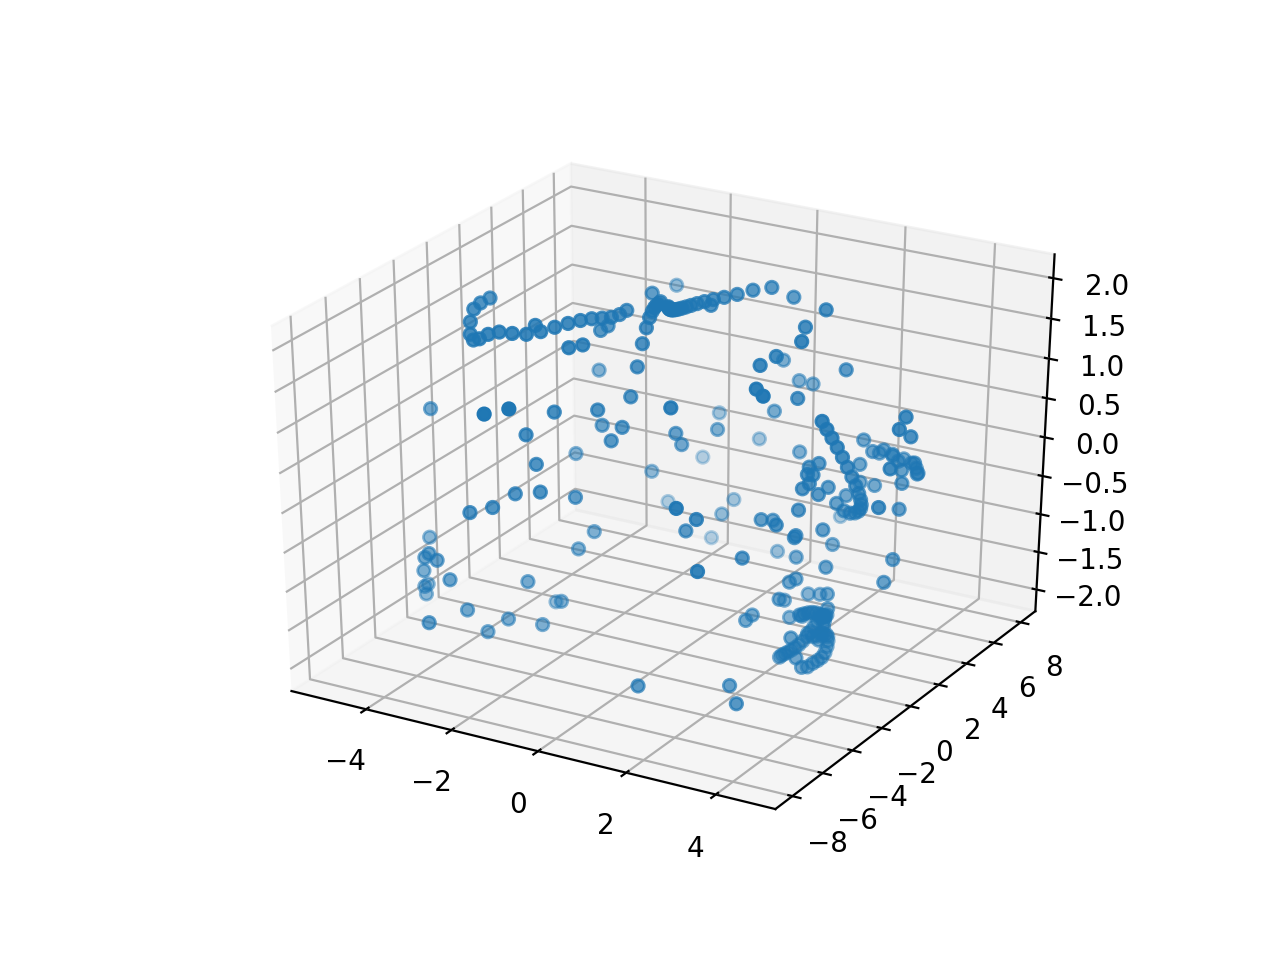

In [7]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:, 0], x[:, 1], x[:, 2])

plt.show()

<IPython.core.display.Javascript object>


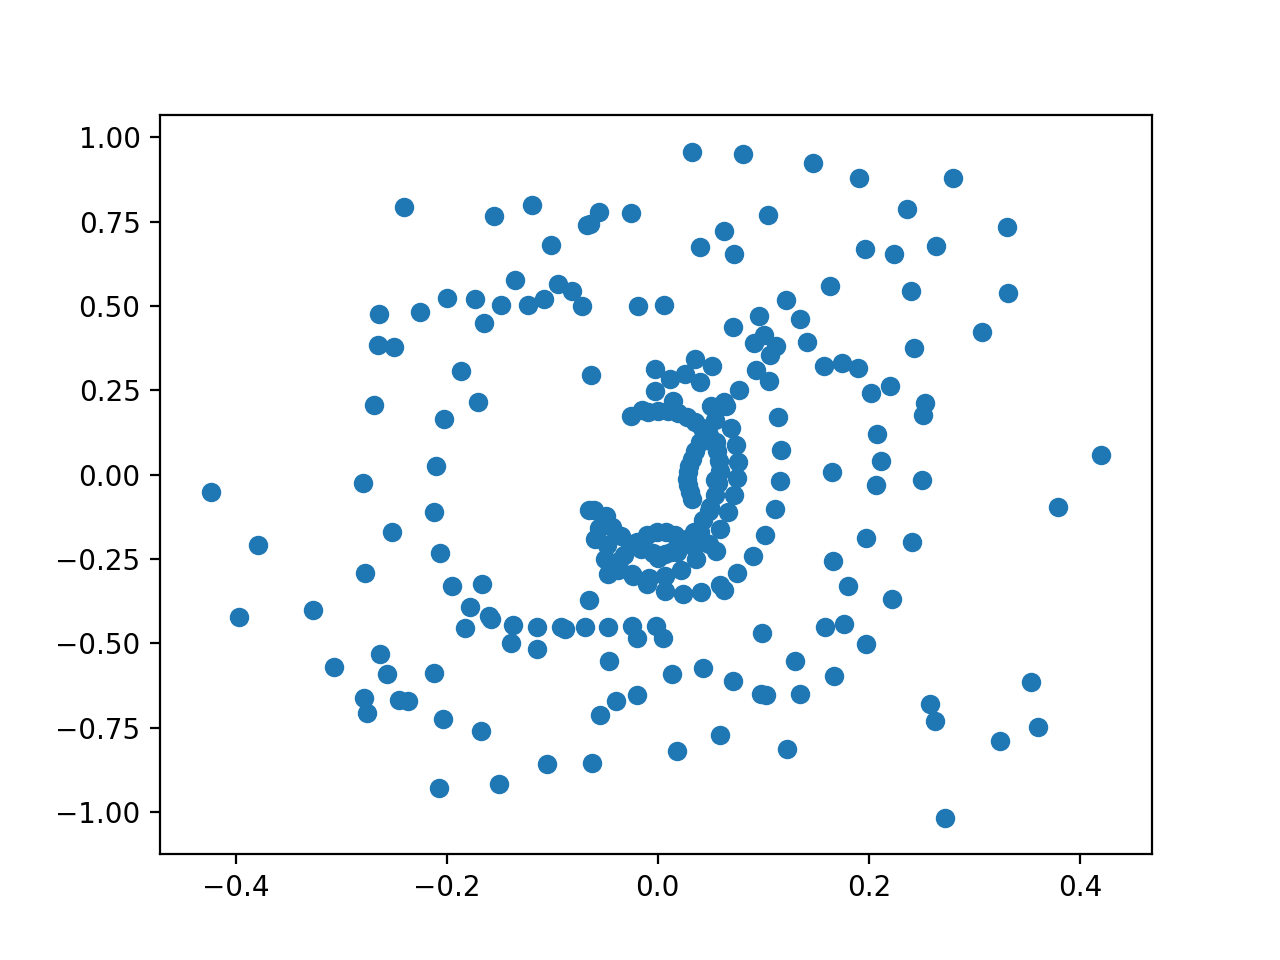

In [8]:
plt.figure()
plt.scatter(y[:, 0], y[:, 1])

<IPython.core.display.Javascript object>


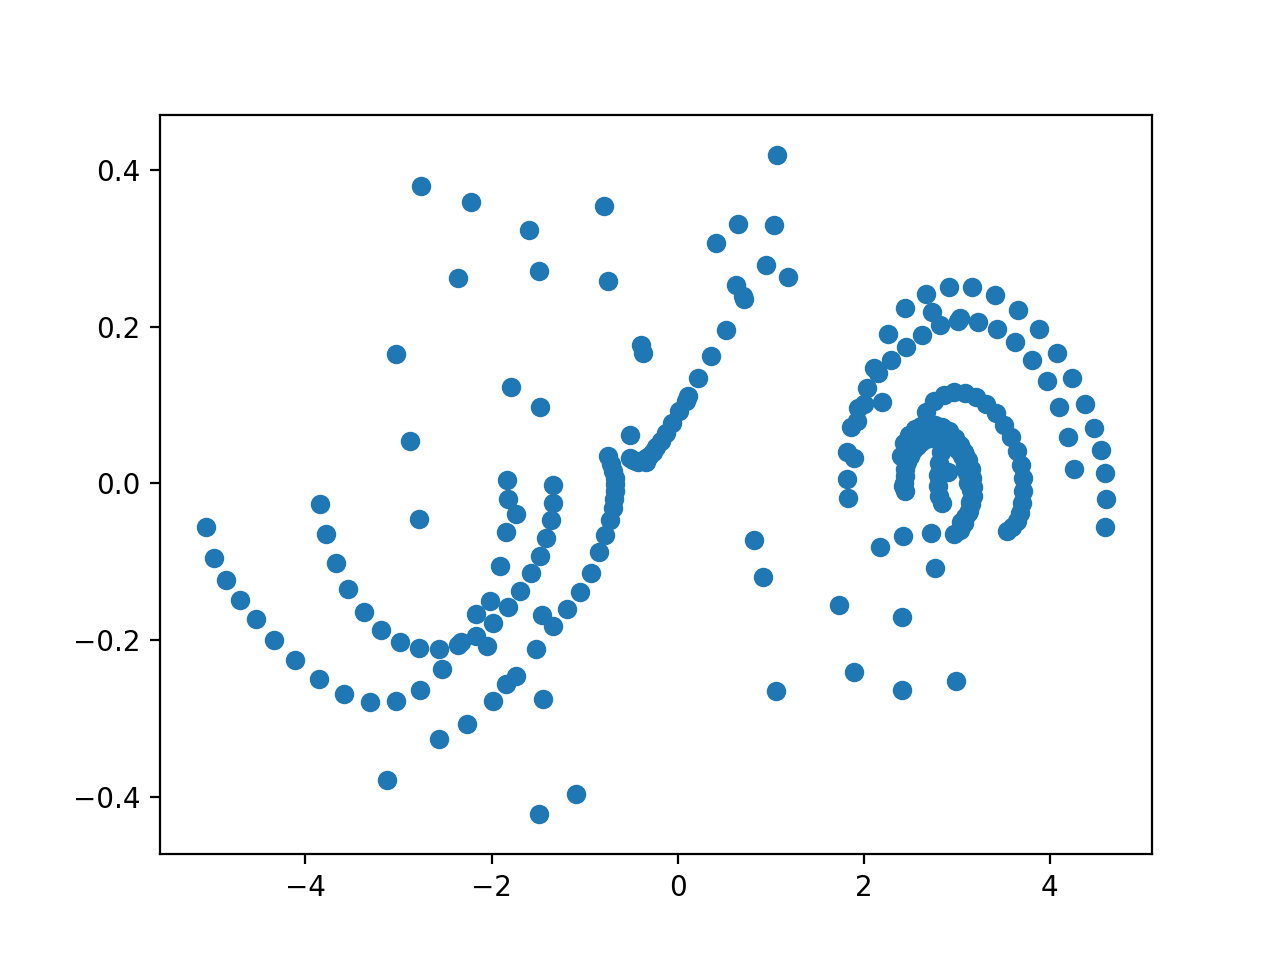

In [9]:
plt.figure()
plt.scatter(x[:,0], y[:,0])

In [3]:
help(env.env.close)

Help on method close in module gym.envs.classic_control.cartpole:

close() method of gym.envs.classic_control.cartpole.CartPoleEnv instance
    Override close in your subclass to perform any necessary cleanup.
    
    Environments will automatically close() themselves when
    garbage collected or when the program exits.

